In [1]:
import os, sys, urllib, gzip
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

In [2]:
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image
import glob
import time
import os
import scipy

In [3]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

Using gpu device 0: GeForce GT 630M (CNMeM is disabled, CuDNN not available)
/home/igor/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')

Using lasagne.layers (slower)


In [5]:
region_width = 28
region_height = 28
#frameMult = 4
frameMult = 8
l_rw=region_width*frameMult
l_rh=region_height*frameMult
l_rS=l_rw*l_rh
l_colors=3
#an_min=-10
#an_max=11
an_min=-3
an_max=3
#an_min=-5
#an_max=5



In [6]:
def load_mnist(fname = 'mnist.pkl.gz'):
    if not os.path.isfile(fname):
        try:
            testfile = urllib.request.URLopener()
        except:
            testfile = urllib.URLopener()
        testfile.retrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", fname)
    f = gzip.open(fname, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()
    Xmono, y = train_set
    Xmono_test=test_set
###############################
    Xcolor_test1=[]
    i=-1
    for pict in Xmono_test[0]:
        i+=1
        d1=np.rollaxis(np.array(zip(pict,pict,pict)).reshape(l_rw,l_rh,3), 2, 0)
        Xcolor_test1.extend([d1])
    Xcolor_test1=np.asarray(Xcolor_test1, dtype=np.float32)                   


    Xcolor1=[]
    ycolor1=[]
    i=-1
    for pict in Xmono:
        i+=1
        if y[i]<=3 :
            d=np.rollaxis(np.array(zip(pict,[0]*l_rS,[0]*l_rS)).reshape(l_rw,l_rh,l_colors), 2, 0)
        elif y[i]<=7:
            d=np.rollaxis(np.array(zip([0]*l_rS,pict,[0]*l_rS)).reshape(l_rw,l_rh,l_colors), 2, 0)
        else:  
            d=np.rollaxis(np.array(zip([0]*l_rS,[0]*l_rS,pict)).reshape(l_rw,l_rh,l_colors), 2, 0)
        ycolor1.extend([d])
        d1=np.rollaxis(np.array(zip(pict,pict,pict)).reshape(l_rw,l_rh,l_colors), 2, 0)
        Xcolor1.extend([d1])
    Xcolor1=np.asarray(Xcolor1, dtype=np.float32)
    ycolor1=np.asarray(ycolor1, dtype=np.float32)

    X_out1 = ycolor1.reshape((Xcolor1.shape[0], -1))
    return Xcolor1,X_out1,Xcolor_test1 
    
    

In [7]:
def get_pictures2np(dir_reg='pechen1_reg',dir_100='pechen224'):
    example_file = [f for f in glob.glob(os.path.join(dir_reg,'*.*')) if ".JPG" in f or ".jpg" in f or "." in f]
    y_region=[]
    x_original=[]
    fnames=[]
    ii=0
    for f in example_file:
        #im = scipy.misc.imread(f)
        f_orig=os.path.join(dir_100,os.path.basename(f))
        if os.path.exists(f_orig):
            ii+=1
            fnames.extend([os.path.basename(f)])
            im_region  = Image.open(f)
            im_orig=Image.open(f_orig)
            l_im_orig3 = np.array(im_orig.resize((l_rw, l_rh), Image.BILINEAR)).reshape(l_rS,-1) # linear interpolation in a 2x2 environment
            l_im_reg3  = np.array(im_region.resize((l_rw, l_rh), Image.BILINEAR)).reshape(l_rS,-1)     # linear interpolation in a 2x2 environment
            im4 = []
            for pix in range(l_rS) :
                d00=[0,0,0]
                #print("pix ",pix,"orig3 ",l_im_orig3[pix][0])
                #if l_im_orig3[pix][0]<20:
                if l_im_orig3[pix][0]<10:
                    d00=[0,0,0]
                else:
                    if l_im_reg3[pix][0]>2 or l_im_reg3[pix][0]> l_im_orig3[pix][0]:
                        #d00=[0,l_im_orig3[pix][0],0]
                        #d00=[0,255,0]
                        d00=[l_im_orig3[pix][0],l_im_orig3[pix][0],l_im_orig3[pix][0]]
                    else:
                        #d00=[0,0,255]
                        d00=[0,0,0]
                im4.extend(d00)    
                
                #if l_im_reg3[pix][0]>50:
                #    im4.extend([0,l_im_orig3[pix][0],0])
                #else :
                #    im4.extend([0,0,255])
                
            y_region.extend([im4])
            if l_im_orig3.shape[1]==1:
                d1=np.array(zip(l_im_orig3,l_im_orig3  ,l_im_orig3))
            else:
                d1=np.array(l_im_orig3)
            
            x_original.extend([d1])
        else:
            print (" no file "+f_orig)

    return fnames,np.array(x_original).reshape(ii,l_rw,l_rh,-1),np.array(y_region).reshape(ii,l_rw,l_rh,-1)

def get_transformedImgages(P_images,p_angle=1,p_pixcut=0):
    destImages=[]
    for ii1 in range(P_images.shape[0]):
        if p_angle!=0:
            im21= np.array(Image.fromarray(np.uint8(P_images[ii1])).rotate(p_angle))
        else:
            im21= np.array(Image.fromarray(np.uint8(P_images[ii1])))
        if (frameMult<2):
            destImages.extend([im21])
        else:
            for dy in range(frameMult):
                for dx in range(frameMult):
                    y1=dy*region_height
                    x1=dx*region_width
                    y2=y1+region_height
                    x2=x1+region_width
                    im22=im21[y1:y2,x1:x2]
                    #print (im22.shape)
                    destImages.extend([im22])
                
    
    return np.array(destImages)    

def get_transformedData(p_x_orig,p_y_reg):
    l_X=[]
    l_y=[]
    for an in np.arange(an_min,an_max):
        rot_orig=get_transformedImgages(p_x_orig,p_angle=an)
        for ii1 in range(rot_orig.shape[0]):
            d0=rot_orig[ii1]
            #d1=np.rollaxis((d0+1.)/256., 2, 0)
            d1=np.rollaxis((d0)/256., 2, 0)
            l_X.extend([d1])
    
        rot_reg =get_transformedImgages(p_y_reg,p_angle=an)
        for ii1 in range(rot_reg.shape[0]):
            d0=rot_reg[ii1]
            #d1=np.rollaxis((d0+1.)/256., 2, 0)
            d1=np.rollaxis((d0)/256., 2, 0)
            l_y.extend([d1])

    return np.asarray(l_X, dtype=np.float32),np.asarray(l_y, dtype=np.float32)


def getNTile(p_NN=0,p_dx=0,p_dy=0,p_angle=0,p_Pictures=89):
    l_angleIdx=p_angle-an_min
    #print ("l_angleIdx is %i" % l_angleIdx)
    l_GlobalOffset=l_angleIdx*p_Pictures*frameMult*frameMult
    #print ("l_GlobalOffset is %i picures %i frames%i" % (l_GlobalOffset, p_Pictures,p_frames))

    l_NNOffset=p_NN*frameMult*frameMult
    #print ("l_NNOffset is %i" % l_NNOffset)
    l_YOffset=p_dy*frameMult
    #print ("l_YOffset is %i" % l_YOffset)
    l_XOffset=p_dx
    #print ("l_XOffset is %i" % l_XOffset)
    return l_GlobalOffset+l_NNOffset+l_YOffset+l_XOffset


def GetWholeIdxes(p_NN=0,p_angle=0):
    idxes=[]
    for dy in range(frameMult):
        for dx in range(frameMult):
            idxes.extend([getNTile(p_NN=p_NN,p_dx=dx,p_dy=dy,p_angle=p_angle)])
    return np.array(idxes)             

def GetWholeFrames(p_Xcolor,p_nn,p_angle=0):
    idxes1=GetWholeIdxes(p_NN=p_nn,p_angle=p_angle)
    #print (idxes1)
    X_input=[]
    for idx in idxes1:
        X_input.extend(p_Xcolor[idx])
    X_input222=np.array(X_input).reshape(-1,l_colors, region_width, region_height)
    return X_input222





def PredictByWholeImg(p_Xcolor,p_nn,p_angle=0):
    X_input2=GetWholeFrames(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    X_out22 = ae.predict(X_input2).reshape(-1,l_colors, region_width, region_height)
    return X_out22 


def AssembleImage(p_FramesImage):
    dst_im22 = Image.new("RGB", (frameMult*region_width,frameMult*region_height), "red" )

    for dy in range(frameMult):
        for dx in range(frameMult):
            #im1=np.uint8(np.rollaxis(p_FramesImage[dy*frameMult+dx], 0, 3)*256.-1.)
            im1=np.uint8(np.rollaxis(p_FramesImage[dy*frameMult+dx], 0, 3)*256.)
            im1= np.clip(im1, a_min = 0, a_max = 255)
            im1  = im1.astype('uint8')
            rot=Image.fromarray(im1)
            dst_im22.paste( rot, (dx*region_width, dy*region_height)) 
    return np.array(dst_im22)  

def GetPicture(p_Xcolor,p_nn,p_angle=0):
    X_input2=GetWholeFrames(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    dst_im22=AssembleImage(X_input2)
    return dst_im22  

def PredictByWholeImgFull(p_Xcolor,p_nn,p_angle=0):
    #print (p_Xcolor.shape)
    X_out22 = PredictByWholeImg(p_Xcolor=p_Xcolor,p_nn=p_nn,p_angle=p_angle)
    #print (X_out22.shape)
    #for i_nn in range(X_out22.shape[0]):
    #    for dy in range(X_out22.shape[2]):
    #        for dx in range(X_out22.shape[3]):
    #            X_out22[i_nn][0][dy][dx]=0
    #            X_out22[i_nn][2][dy][dx]=0
                
    dst_im22=AssembleImage(X_out22)
    return dst_im22  





def MergePredict_Original(p_original,p_predict):
    l_region_width=p_original.shape[0]
    l_region_height=p_original.shape[1]
    
    im11 = p_original.reshape(l_region_width*l_region_height,-1) 
    im3  = p_predict.reshape(l_region_width*l_region_height,-1) 
    
    im4=[]
    for pix in range(l_rS) :
        if im3[pix][0]>10   :
            im4.extend([im11[pix][0],im11[pix][1]/4,im11[pix][2]/4])
        else:
            im4.extend(im11[pix])
    return  np.array(im4).reshape(p_original.shape[0],p_original.shape[1],p_original.shape[2]).astype('uint8')        

    

In [8]:
def load_pechen():
    fnames,x_original1,y_region1=get_pictures2np()
    print ("loaded shape:",x_original1.shape,y_region1.shape)
    Xcolor1,ycolor1=get_transformedData(p_x_orig=x_original1,p_y_reg=y_region1)
    print ("transformed shape:",Xcolor1.shape,ycolor1.shape)
    
    X_out1 = ycolor1.reshape((Xcolor1.shape[0], -1))
    print (X_out1.shape)
    return Xcolor1,X_out1,Xcolor1,ycolor1,fnames,x_original1,y_region1


In [9]:
# print(l_rh,l_rw)
Xcolor,X_out,Xcolor_test,ycolor,fnames,x_original,y_region=load_pechen()
#Xcolor,X_out,Xcolor_test=load_mnist()

loaded shape: (89, 224, 224, 3) (89, 224, 224, 3)
transformed shape: (34176, 3, 28, 28) (34176, 3, 28, 28)
(34176, 2352)


(34176, 3, 28, 28) (34176, 2352)
[128 128 128]


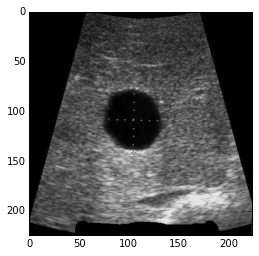

In [10]:
nn=6
#print(l_rS,224*224)
print(Xcolor.shape,X_out.shape)
#im_learn=GetPicture(X_out,p_nn=nn)
im_learn=GetPicture(Xcolor,p_nn=nn)
plt.imshow(np.array(im_learn))
#print (im_learn.shape);
print (np.array(im_learn)[200][100])


(34176, 3, 28, 28) (34176, 2352)
[0 0 0]


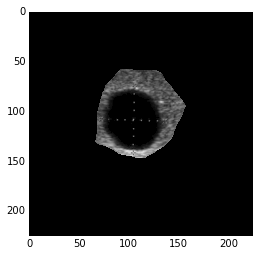

In [11]:
nn=6
#print(l_rS,224*224)
print(Xcolor.shape,X_out.shape)
im_learn=GetPicture(X_out,p_nn=nn)
#im_learn=GetPicture(Xcolor,p_nn=nn)
plt.imshow(np.array(im_learn))
#print (im_learn.shape);
print (np.array(im_learn)[200][100])


In [12]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
#encode_size = 16
#dense_mid_size = 128
encode_size = 32
dense_mid_size = 256
pad_in = 'valid'
pad_out = 'full'
dense_last_layer=((Xcolor.shape[2]-2*(filter_size-1))/pool_size-(filter_size-1))/pool_size
layers = [
    (InputLayer, {'shape': (None, Xcolor.shape[1], Xcolor.shape[2], Xcolor.shape[3])}), 
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (Conv2DLayerFast, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayerFast, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    #(DenseLayer, {'num_units': 800}),
    #(ReshapeLayer, {'shape': (([0], 2*conv_num_filters, 5, 5))}),
    (DenseLayer, {'num_units': 2*conv_num_filters*dense_last_layer* dense_last_layer}),
    
    (ReshapeLayer, {'shape': (([0], 2*conv_num_filters, dense_last_layer, dense_last_layer))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerFast, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayerSlow, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Conv2DLayerSlow, {'num_filters': l_colors, 'filter_size': filter_size, 'pad': pad_out}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [13]:
ae = NeuralNet(
    layers=layers,
    max_epochs=200,
    
    update=nesterov_momentum,
    update_learning_rate=0.025,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)
# ae.initialize()
# PrintLayerInfo()(ae)

    101       0.00506       0.01023      0.49417  345.19s
    102       0.00456       0.01000      0.45573  357.75s
    103       0.00457       0.01059      0.43161  378.18s
    104       0.00466       0.01232      0.37865  485.48s
    105       0.00473       0.01475      0.32048  318.50s
    106       0.00460       0.01607      0.28658  338.17s
    107       0.00443       0.01659      0.26673  326.24s
    108       0.00434       0.01521      0.28528  335.51s
    109       0.00421       0.01333      0.31577  419.41s
    110       0.00413       0.01255      0.32867  323.99s
    111       0.00406       0.01290      0.31509  346.52s
    112       0.00406       0.01357      0.29891  353.71s
    113       0.00407       0.01497      0.27162  344.32s
    114       0.00411       0.01568      0.26218  349.73s
    115       0.00419       0.01617      0.25934  321.93s
    116       0.00431       0.01602      0.26921  292.59s
    117       0.00448       0.01732      0.25858  292.61s
    118       

<module 'matplotlib.pyplot' from '/usr/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

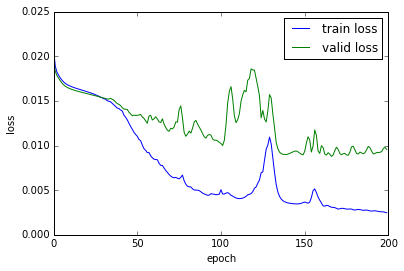

In [17]:
ae.fit(Xcolor, X_out)
pickle.dump(ae, open('conv_ae_medical224_7_BWIn.pkl','wb'))

from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)

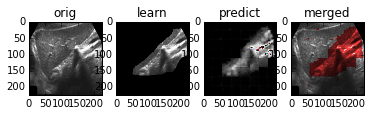

In [39]:
nn=8
dst_im = PredictByWholeImgFull(p_Xcolor=Xcolor,p_nn=nn)
dst_im_merge=MergePredict_Original(x_original[nn],dst_im)

sub1 = plt.subplot(1, 4,1)
plt.imshow( x_original[nn])
sub1.set_title("orig")

sub2 = plt.subplot(1, 4, 2)
plt.imshow(y_region[nn]/256.)
sub2.set_title("learn")

sub3 = plt.subplot(1, 4, 3)
plt.imshow(dst_im)
sub3.set_title("predict")

sub4 = plt.subplot(1, 4, 4)
plt.imshow(dst_im_merge)
sub4.set_title("merged")



(224, 224, 3)


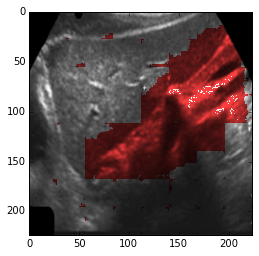

In [40]:
dst_im = PredictByWholeImgFull(p_Xcolor=Xcolor,p_nn=nn)
print(dst_im.shape)
#for dx in range(dst_im.shape[0]):
#    for dy in range(dst_im.shape[1]):
#        dst_im[dx][dy][0]=0
#        dst_im[dx][dy][1]=dst_im[dx][dy][1] if dst_im[dx][dy][1]>20 and dst_im[dx][dy][1]<250 else 0
#        dst_im[dx][dy][2]=0
        
dst_im2=MergePredict_Original(x_original[nn],dst_im)
        
plt.imshow(dst_im2)
#print (x_original[nn][100,:,:]) 

In [ ]:
#plt.imshow(dst_im_merge)
print (X_out[200].reshape(3,28,28)[1])

In [15]:
ae = pickle.load(open('conv_ae_medical224_7_BWIn_005prc.pkl','rb'))

In [ ]:
start_time = time.time()
X_pred = ae.predict(Xcolor).reshape(-1,3, 28, 28)
print("took {:.3f}s".format(time.time() - start_time))

print(X_pred.shape, Xcolor_test.shape , Xcolor.shape,X_test.shape)

In [ ]:
range(10)[-1]

In [ ]:
next_layer = ae.get_all_layers()[encode_layer_index + 1]
final_layer = ae.get_all_layers()[-1]
new_layer = InputLayer(shape=(None, encode_layer.num_units))

# N.B after we do this, we won't be able to use the original autoencoder , as the layers are broken up
next_layer.input_layer = new_layer

In [ ]:
def get_output_from_nn(last_layer, X):
    return get_output(last_layer,X).eval()

def decode_encoded_input(X):
    return get_output_from_nn(final_layer, X)

#X_decoded = 256 * decode_encoded_input(X_encoded[2])
X_decoded = 256 * decode_encoded_input(X_encoded[np.random.randint(10000)])


X_decoded = np.rint(X_decoded).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
print(X_decoded.shape)
dd2=np.rollaxis(X_decoded.reshape(3,28,28), 0, 3)
print(dd2.shape)
pic_array = get_picture_arrayC(X_decoded)
print (pic_array.shape)
#image = Image.fromarray(pic_array,'RGB')
#imshow(np.rollaxis(X_decoded.reshape(3,28,28), 0, 3))
#image.save('data/test.png', format="PNG")  
#IPImage('data/test.png')


In [ ]:
enc_std = X_encoded.std(axis=0)
enc_mean = X_encoded.mean(axis=0)
enc_min = X_encoded.min(axis=0)
enc_max = X_encoded.max(axis=0)
m = X_encoded.shape[1]

In [ ]:
n = 256
generated = np.random.normal(0, 1, (n, m)) * enc_std + enc_mean
generated = generated.astype(np.float32).clip(enc_min, enc_max)
X_decoded = decode_encoded_input(generated) * 256.
X_decoded = np.rint(X_decoded ).astype(int)
X_decoded = np.clip(X_decoded, a_min = 0, a_max = 255)
X_decoded  = X_decoded.astype('uint8')
!mkdir -p montage
for i in range(n):
    pic_array = get_picture_array(X_decoded[i], rescale=1)
    image = Image.fromarray(pic_array)
    image.save('montage/{0:03d}.png'.format(i), format='png')

In [ ]:
!montage -mode concatenate -tile 16x montage/*.png montage.png
IPImage('montage.png')